# Práctica 3 Visión por Computador
##### Antonio Cabrera, Alejandro Gómez y Alvaro Salís
---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import torchvision.models as models
import torchvision.utils as vutils
import os
import shutil
import py7zr

## 1. Cargar los datos

Descomprimir el dataset

Creamos el objeto dataloader

In [2]:
dataset_path = 'dataset'
image_size = 64

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

Vamos a ver como son las imágenes del dataset.

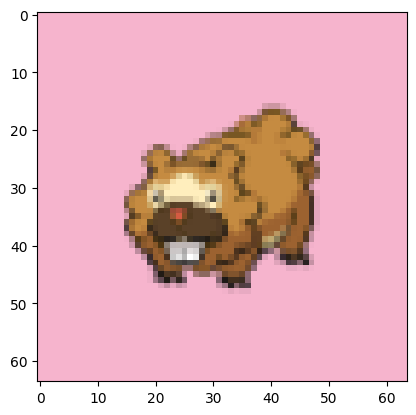

In [3]:
# Obtener un batch
images_batch, _ = next(iter(dataloader))
plt.imshow(np.transpose(images_batch[0].numpy(), (1, 2, 0)) * 0.5 + 0.5) # Des-normalizar para ver
plt.show()

### 2. Crear el modelo

Generador:
- `nz`: Tamaño del vector de ruido (latente), usualmente 100.
- `nc`: Número de canales de color (3 para RGB).
- `ngf`: Número de filtros de las capas convolucionales.

En vez de utilizar capas `ConvTranspose2d` las cuales hacen upsampling y posteriormente las convoluciones necesitamos dividir el proceso en dos capas:
- `Upsample` con modo *nearest* el cual es óptimo para pixelart.
- `Conv2d` normal.

In [4]:
 class Generator(nn.Module):
    def __init__(self, nz=100, nc=3, ngf=64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Entrada: vector Z (ej. 100)
            # Capa 1: De vector a 4x4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Capa 2: 4x4 -> 8x8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Capa 3: 8x8 -> 16x16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Capa 4: 16x16 -> 32x32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Capa de Salida: 32x32 -> 64x64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            # Tanh comprime la salida entre [-1, 1], vital para GANs
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input) 

Discriminador:
- `nc`: Número de canales de color (3 para RGB).
- `ndf`: Número de filtros de las capas convolucionales.

Un problema habitual de las GANs es que modelo colapse, es decir, que el generador siempre "engañe" al discriminador con las mismas imágenes. Para paliarlo podemos utilizar `spectral_norm()`.

Sin `spectral_norm()`, el discriminador cambia muy rápido de "nota" ante pequeños cambios de las imágenes generadas (como cambiar 3 píxeles). Esto causa que el generador se centre en las mismas imágenes.

In [5]:
class Discriminator(nn.Module):
  def __init__(self, nc=3, ndf=64):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
      # Entrada: Imagen 3 x 64 x 64
      # Capa 1: 64x64 -> 32x32
      spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
      nn.LeakyReLU(0.2, inplace=True),


      # Capa 2: 32x32 -> 16x16
      spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(0.2, inplace=True),


      # Capa 3: 16x16 -> 8x8
      spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),


      # Capa 4: 8x8 -> 4x4
      spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
      nn.BatchNorm2d(ndf * 8),
      nn.LeakyReLU(0.2, inplace=True),


      # Salida: 4x4 -> Probabilidad escalar (1 valor)
      spectral_norm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),

      nn.Sigmoid()
      # Sigmoid convierte el número en una probabilidad entre 0 y 1
    )

  def forward(self, input):
    return self.main(input)

## 3. Entrenar el modelo

Primero instanciamos las redes neuronales del generador y el discriminador.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

Definimos la función de perdida y los optimizadores de cada red neuronal.

In [7]:
# Configuración recomendada para GANs con Spectral Norm

# 1. Learning Rates diferenciados (TTUR)
lr_d = 0.0004  # El Discriminador va más rápido (x2 o x4 veces el G)
lr_g = 0.0001  # El Generador va más lento para refinar detalles

# 2. Betas ajustados (CRUCIAL: Beta1 = 0.0 o 0.5)
# (0.5, 0.999) es el punto dulce para la mayoría de casos.
mis_betas = (0.5, 0.999) 

optimizer_G = optim.Adam(G.parameters(), lr=lr_g, betas=mis_betas)
optimizer_D = optim.Adam(D.parameters(), lr=lr_d, betas=mis_betas)

criterion = nn.BCELoss()

Crear carpeta donde se generarán las imágenes durante el entrenamiento

In [8]:
dir_name = "gan_images"

# 1. Si la carpeta ya existe, la borramos completa con todo su contenido
if os.path.exists(dir_name):
    shutil.rmtree(dir_name)

# 2. La volvemos a crear limpia
os.makedirs(dir_name)

Entrenamos el modelo.

In [9]:
epochs = 500
nz = 100
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # 64 imágenes de prueba fijas
print("Starting training...")
for epoch in range(epochs):
    # Inicializamos acumuladores para ver el promedio de la época, no solo el último batch
    d_loss_accum = 0.0
    g_loss_accum = 0.0
    
    for batch_X, _ in dataloader:
        batch_X = batch_X.to(device)
        batch_size = batch_X.size(0)

        # Labels
        real_labels = torch.full((batch_size,), 0.9, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        D.zero_grad()
        outputs_real = D(batch_X).view(-1)
        loss_real = criterion(outputs_real, real_labels)

        z = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = G(z)
        outputs_fake = D(fake_images.detach()).view(-1)
        loss_fake = criterion(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        G.zero_grad()
        outputs = D(fake_images).view(-1)
        loss_G = criterion(outputs, real_labels)  # queremos que el D piense que son reales
        loss_G.backward()
        optimizer_G.step()

        # Actualizar acumuladores
        d_loss_accum += loss_D.item()
        g_loss_accum += loss_G.item()

    avg_d_loss = d_loss_accum / len(dataloader)
    avg_g_loss = g_loss_accum / len(dataloader)

    print(f"[{epoch+1}/{epochs}] - AVG Discriminator loss: {avg_d_loss:.2f}, AVG Generator loss: {avg_g_loss:.2f}")
        
    # Cada 10 épocas guardar una imágen generada
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            # Ponemos el modelo en eval por si tienes BatchNorm/Dropout
            G.eval()
            fake_plot = G(fixed_noise).detach().cpu()
            # save_image crea una cuadrícula automática muy útil
            vutils.save_image(fake_plot, f"gan_images/epoch_{epoch+1}.png", normalize=True)
            G.train() # Volvemos a modo entrenamiento

Starting training...
[1/500] - AVG Discriminator loss: 0.45, AVG Generator loss: 10.00
[2/500] - AVG Discriminator loss: 0.35, AVG Generator loss: 7.27
[3/500] - AVG Discriminator loss: 0.38, AVG Generator loss: 5.98
[4/500] - AVG Discriminator loss: 0.39, AVG Generator loss: 5.43
[5/500] - AVG Discriminator loss: 0.36, AVG Generator loss: 6.01
[6/500] - AVG Discriminator loss: 0.37, AVG Generator loss: 5.50
[7/500] - AVG Discriminator loss: 0.37, AVG Generator loss: 5.86
[8/500] - AVG Discriminator loss: 0.37, AVG Generator loss: 5.43
[9/500] - AVG Discriminator loss: 0.39, AVG Generator loss: 5.62
[10/500] - AVG Discriminator loss: 0.38, AVG Generator loss: 5.18
[11/500] - AVG Discriminator loss: 0.36, AVG Generator loss: 5.57
[12/500] - AVG Discriminator loss: 0.35, AVG Generator loss: 5.76
[13/500] - AVG Discriminator loss: 0.36, AVG Generator loss: 5.39
[14/500] - AVG Discriminator loss: 0.37, AVG Generator loss: 5.31
[15/500] - AVG Discriminator loss: 0.37, AVG Generator loss: 5.

## 4. Evaluar el modelo

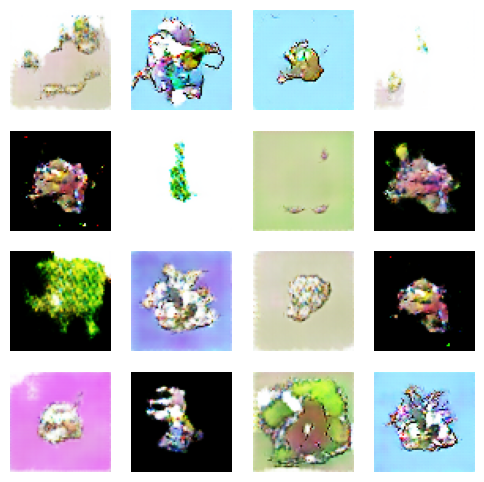

In [10]:
z = torch.randn(16, nz, 1, 1).to(device)
fake_images = G(z).cpu().detach()

fig, axes = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5) # Des-normalizar para ver
    ax.axis('off')
plt.show()